# LANL Earthquake Prediction Kaggle Competition



### What is this competition about ?

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: **when** the event will occur, **where** it will occur, and **how large** it will be.

In this competition, we will address **when** the earthquake will take place. Specifically, we’ll predict **the time remaining** before laboratory earthquakes occur from real-time seismic data.

Together we will cover the first place solution.

Our steps will be :
*  1 - Installing dependencies
*  2 - Importing dataset
*  3 - Exploratory data analysis
*  4 - Feature engineering
*  5 - Creating Test and Train Sets
*  6 - Preparing Cross Validation 
*  7 - Train The LightGBM
*  8 - Train The NN
*  9 - Combining NN and LGBM using geometric mean

## 1- Installing Dependencies

In [1]:
from tensorflow import keras
from keras.layers import (BatchNormalization,Flatten,Convolution1D,Activation,Input,Dense,LSTM)
from tsfresh.feature_extraction import feature_calculators
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import Sequence, to_categorical
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau
from keras import losses, models, optimizers
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm   
from joblib import Parallel, delayed
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import lightgbm as lgb
import seaborn as sns
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import librosa
import pywt
import os
import gc

#it helps us to download the data stored in Kaggle but you have to use an API
!pip install kaggle
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

Using TensorFlow backend.


## 2- Importing Dataset


In [2]:
# changing PATH from C:\Users\dell to C:\Users\dell\LANL-Data
path = r"C:\Users\dell\LANL-Data"
os.chdir( path )


In [3]:
#check  
print(os.getcwd())

C:\Users\dell\LANL-Data


In [4]:
# to see what is inside of LANL-Data
print(os.listdir(os.getcwd()))

['model.hdf5', 'oof_geomean.npy', 'oof_LGBM.npy', 'oof_NN.npy', 'sample_submission.csv', 'submission_geomean.csv', 'submission_LGBM.csv', 'submission_NN.csv', 'sub_geomean.npy', 'sub_LGBM.npy', 'sub_NN.npy', 'test', 'train.csv']


In [5]:
raw = pd.read_csv("train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}) 

## 3- Exploratory Data Analysis

### Training Data : ###

* The training data is a single, continuous segment of experimental data.

* The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, as an artifact of the recording device.

* There are 629,145,480 data points in the training set to train on--this is about 157 seconds of data. 

* The dimension of the data is quite large, in excess of 600 millions rows of data.


In [6]:
raw.head(7)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691


**acoustic_data**  can be interpreted as a seismic signal 

**time_to_failure** corresponds to the time until the laboratory earthquake takes place (quaketime)

When we look at the quaketime (time_to_failure) of these first rows seems to be always the same. But it is not true.


In [7]:
for n in range(5):
    print(raw.time_to_failure.values[n])

1.4690999832
1.4690999821000001
1.4690999809999998
1.4690999799000002
1.4690999787999999


We can see that they are not the same and that pandas has rounded them off. And we can see that the time seems to decrease.

In [16]:
# functions for the plots 
def single_timeseries(final_idx, init_idx=0, step=1, title="",
                      color1='skyblue', color2='rebeccapurple'):
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=raw.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=raw.iloc[idx].time_to_failure.values, ax=ax2, color=color2)
    

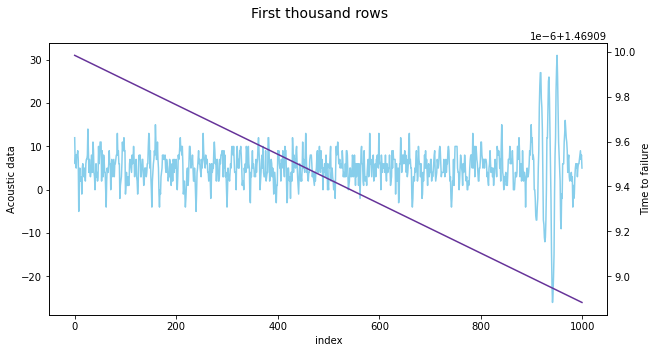

In [17]:
single_timeseries(1000, title="First thousand rows")

The time to failure (TTF) is linearly decreasing at a very slow rate. However, when looking at ten thousand rows it's possible to see some "jumps":

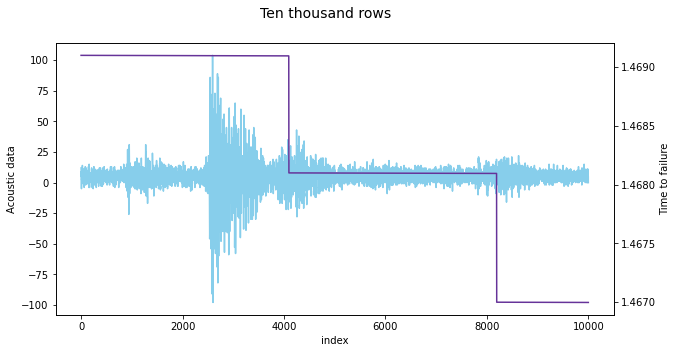

In [18]:
single_timeseries(10000, title="Ten thousand rows")

According to description of data :

**The data is recorded in bins of 4096 samples. Within those bins, there is a 12 microseconds (1e-6) gap between each bin, as an artifact of the recording device.**

So, the "jumps" take 12 microseconds and occur every 4096 measurements.



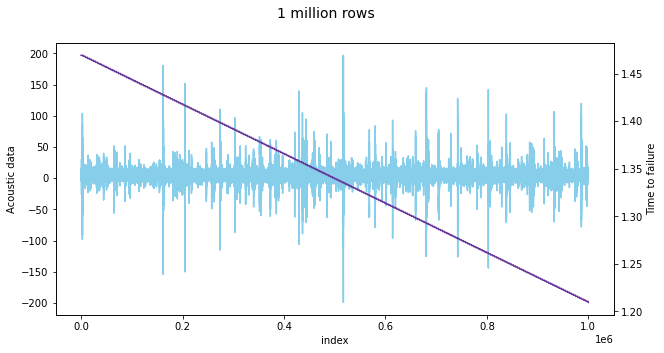

In [21]:
single_timeseries(1000000, title="One million rows")

We can't see the jumps anymore; it's as if we have stretched the line and the steps disappeared.

The next plot has ten million rows, but we are plotting only every 10 data points:

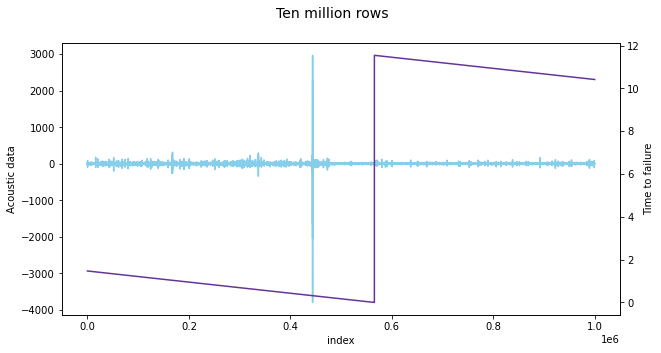

In [19]:
single_timeseries(10000000, step=10, title="Ten million rows")

There is only one huge change in TTF, which is exactly when an earthquake occured and the time goes from almost zero to eleven seconds.

Finally, let's plot all the data (629.145 million rows):

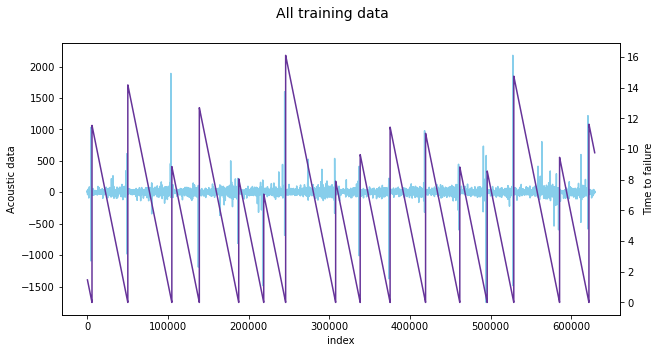

In [20]:
single_timeseries(629145000, step=1000, title="All training data")

There are 16 earthquakes in the train set and that they occur when time_to_failure (quaketime) goes to 0. 

The shortest time to failure is 1.5 seconds for the first earthquake, while the longest is around 16 seconds.

### Test Data : ###

* The test data consists of a folder containing many small segments that may (or may not) correspond to different experiments. The regular pattern we might find in the train set does not match those of the test segments.

* Each segment only has 150,000 data points of seismic data, which corresponds to 0.0375 seconds of seismic data.

* The data *within* each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

* For each test data segment with its corresponding seg_id we are asked to predict **it's single time until the lab earthquake takes place**.

*  There is no overlap between the training and testing sets, that are contiguous in time.

How does the signal of the test data look like?

In [22]:
#changing path from C:\Users\dell\LANL-Data to C:\Users\dell\LANL-Data\test

test_path = r"C:\Users\dell\LANL-Data\test"
os.chdir( test_path )

#check
print(os.getcwd())


C:\Users\dell\LANL-Data\test


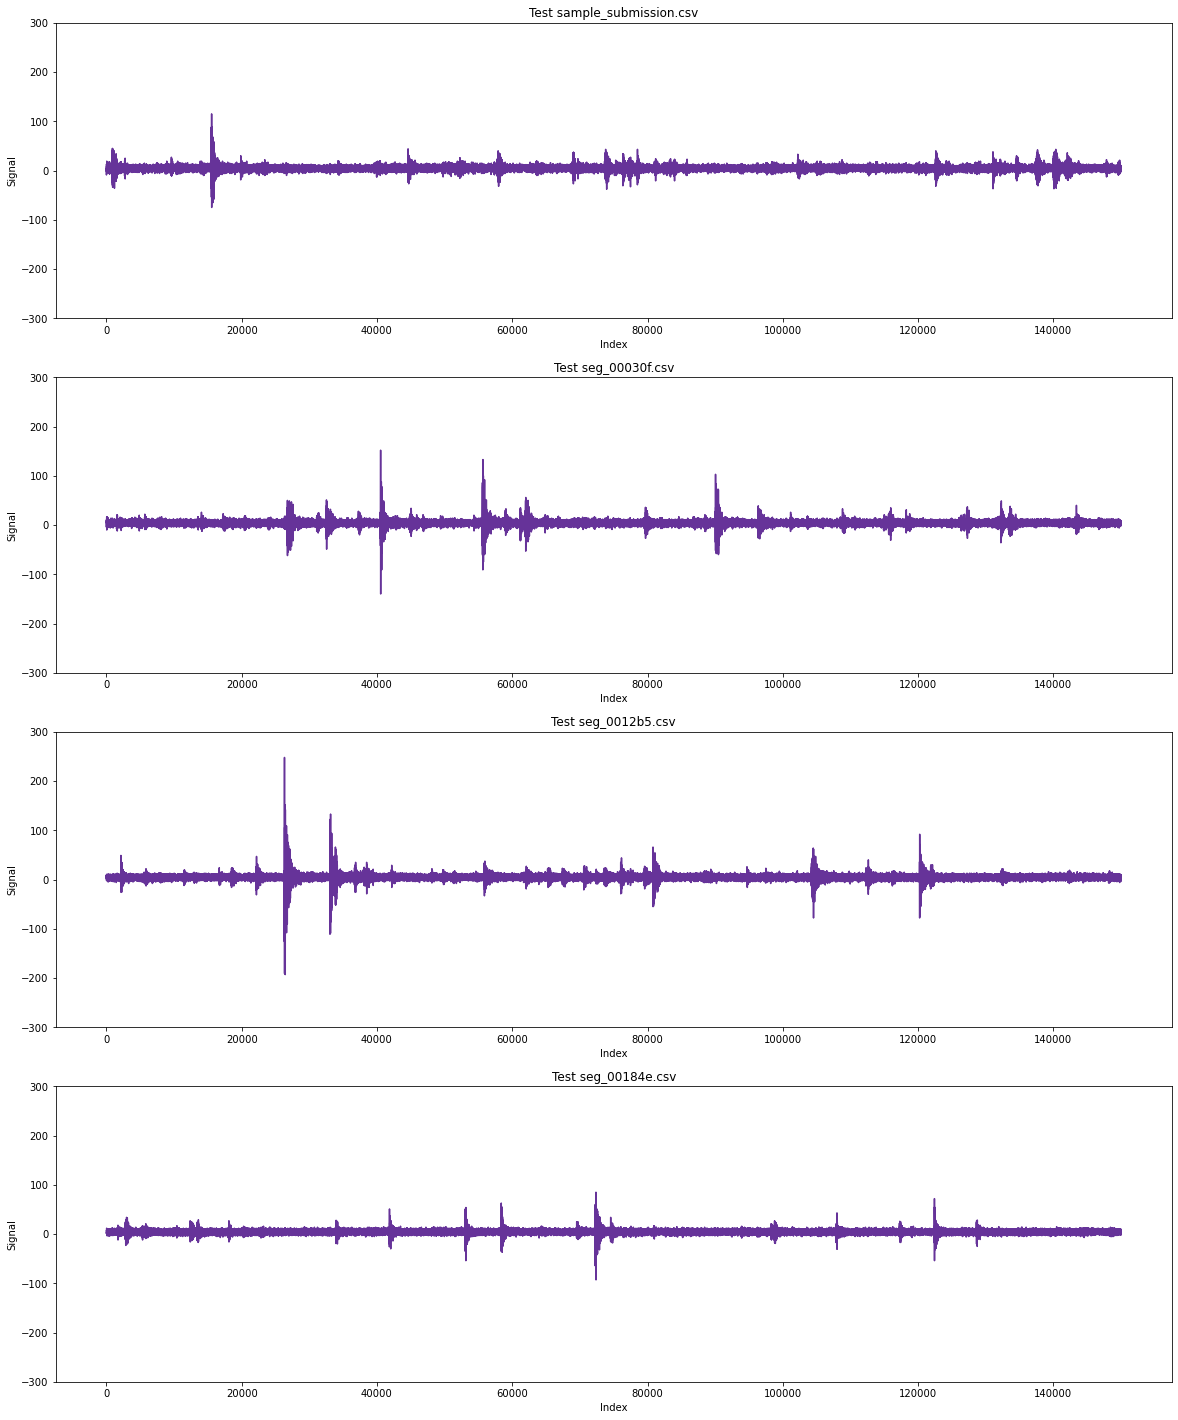

In [23]:
test_files = os.listdir(os.getcwd())  #attaching list of fileswhich is inside the test file to test_file 
fig, ax = plt.subplots(4,1, figsize=(20,25))

for n in range(4):
    seg = pd.read_csv(test_path +str( "\\" ) + str(test_files[n+1]))
    ax[n].plot(seg.acoustic_data.values, c="rebeccapurple")
    ax[n].set_xlabel("Index")
    ax[n].set_ylabel("Signal")
    ax[n].set_ylim([-300, 300])
    ax[n].set_title("Test {}".format(test_files[n]));

These test segment examples differ a lot in the occurences of small peaks that seem to be similar to those in the train data before and after the heavy signal peak that occured some time before the lab earthquake took place.

They probably came from the same experiment but do neither form a continuous signal nor directly follow after the train data.

## 4- Feature Engineering ##

### Functions for parsing and feature generation: ###

##### Normalization function #####

In [24]:
# The normalize function is required to normalize the data for the neural network.

def normalize(X_train, X_valid, X_test, normalize_opt, excluded_feat):
    feats = [f for f in X_train.columns if f not in excluded_feat]
    if normalize_opt != None:
        if normalize_opt == 'min_max':
            scaler = preprocessing.MinMaxScaler()
        elif normalize_opt == 'robust':
            scaler = preprocessing.RobustScaler()
        elif normalize_opt == 'standard':
            scaler = preprocessing.StandardScaler()
        elif normalize_opt == 'max_abs':
            scaler = preprocessing.MaxAbsScaler()
        scaler = scaler.fit(X_train[feats])
        X_train[feats] = scaler.transform(X_train[feats])
        X_valid[feats] = scaler.transform(X_valid[feats])
        X_test[feats] = scaler.transform(X_test[feats])
    return X_train, X_valid, X_test

The python-fit (.fit) module is designed for fitting data simple and painless

##### Create random noise for robustness #####

**Robustness**  is the ability of a computer system to cope with errors during execution and cope with erroneous input. For a machine learning algorithm to be considered robust, either the testing error has to be consistent with the training error, or the performance is stable after adding some noise to the dataset.

*WHY DO WE ADD RANDOM NOISE?* 


Because the signal had a certain time-trend that caused some issues specifically on mean and quantile based features. To partly overcome this, we will add a constant noise to each 150k segment (both in train and test) by calculating np.random.normal(0, 0.5, 150_000). Additionally, after noise addition, we will subtract the median of the each segment.

In [25]:
np.random.seed(1337)
noise = np.random.normal(0, 0.5, 150_000)

#####  Mean Absolute Deviation #####

The absolute mean deviation measures the spread and scatteredness of data around, preferably the median value, in terms of absolute deviation. 

In [26]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

With **d - np.mean(d,axis)**, we extract mean from every element of array d


##### Denoise the raw signal given a segment x #####

In [27]:
def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")  
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per') 

**pywt.wavedec** = returns ordered list of coefficients arrays depending on level of decomposition.

**pywt.threshold** = Thresholds the input data depending on the mode argument. In hard thresholding, the data values where their absolute value is less than the value param are replaced with substitute. Data values with absolute value greater or equal to the thresholding value stay untouched.

**pywt.waverec** =  reconstructs the 1-D signal x based on the multilevel wavelet decomposition structure

##### Denoise the raw signal (simplified) given a segment x #####

In [28]:
def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    #univeral threshold
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

The only difference between **denoise_signal** and **denoise_signal_simple** is the threshold values. For the first one,  we calculate threshold value. However, for the second we specify a constant threshold value.


#####  Generate the features given a segment z #####

We create a dataframe named x to store our features.


In [29]:
def feature_gen(z):
    X = pd.DataFrame(index=[0], dtype=np.float64) #create an empty Dataframe named X 
    
    
    # Add noise, subtract median to remove bias from mean/median as time passes in the experiment
    # Save the result as a new segment, z
    z = z + noise
    z = z - np.median(z)

    # Save denoised versions of z
    den_sample = denoise_signal(z)
    den_sample_simple = denoise_signal_simple(z)
    
    # Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(z)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_denoise_simple = librosa.feature.mfcc(den_sample_simple)
    mfcc_mean_denoise_simple = mfcc_denoise_simple.mean(axis=1) #0-19
    
    # Spectral contrast 
    lib_spectral_contrast_denoise_simple = librosa.feature.spectral_contrast(den_sample_simple).mean(axis=1) #0-6
    lib_spectral_contrast = librosa.feature.spectral_contrast(z).mean(axis=1) #0-6
    
    # Neural network features
    X['NN_zero_crossings_denoise'] = len(np.where(np.diff(np.sign(den_sample)))[0])
    X['NN_LGBM_percentile_roll20_std_50'] = np.percentile(pd.Series(z).rolling(20).std().dropna().values, 50)
    X['NN_q95_roll20_std'] = np.quantile(pd.Series(z).rolling(20).std().dropna().values, 0.95)
    X['NN_LGBM_mfcc_mean4'] = mfcc_mean[4]
    X['NN_lib_spectral_contrast0'] = lib_spectral_contrast[0]
    X['NN_num_peaks_3_denoise'] = feature_calculators.number_peaks(den_sample, 3)
    X['NN_mfcc_mean_denoise_simple2'] = mfcc_mean_denoise_simple[2]
    X['NN_mfcc_mean5'] = mfcc_mean[5]
    X['NN_mfcc_mean2'] = mfcc_mean[2]
    X['NN_mfcc_mean_denoise_simple5'] = mfcc_mean_denoise_simple[5]
    X['NN_absquant95'] = np.quantile(np.abs(z), 0.95)
    X['NN_median_roll50_std_denoise_simple'] = np.median(pd.Series(den_sample_simple).rolling(50).std().dropna().values)
    X['NN_mfcc_mean_denoise_simple1'] = mfcc_mean_denoise_simple[1]
    X['NN_quant99'] = np.quantile(z, 0.99)
    X['NN_lib_zero_cross_rate_denoise_simple'] = librosa.feature.zero_crossing_rate(den_sample_simple)[0].mean()
    X['NN_fftr_max_denoise'] = np.max(pd.Series(np.abs(np.fft.fft(den_sample)))[0:75000])
    X['NN_abssumgreater15'] = np.sum(abs(z[np.where(abs(z)>15)]))
    X['NN_LGBM_mfcc_mean18'] = mfcc_mean[18]
    X['NN_lib_spectral_contrast_denoise_simple2'] = lib_spectral_contrast_denoise_simple[2]
    X['NN_fftr_sum'] = np.sum(pd.Series(np.abs(np.fft.fft(z)))[0:75000])
    X['NN_mfcc_mean_denoise_simple10'] = mfcc_mean_denoise_simple[10]
    
    # Extra features only LGBM used.
    X['LGBM_num_peaks_2_denoise_simple'] = feature_calculators.number_peaks(den_sample_simple, 2)
    X['LGBM_autocorr5'] = feature_calculators.autocorrelation(pd.Series(z), 5)
    
    # Windowed fast fourier transformations
    fftrhann20000 = np.sum(np.abs(np.fft.fft(np.hanning(len(z))*z)[:20000]))
    fftrhann20000_denoise = np.sum(np.abs(np.fft.fft(np.hanning(len(z))*den_sample)[:20000]))
    fftrhann20000_diff_rate = (fftrhann20000 - fftrhann20000_denoise)/fftrhann20000
    
    X['LGBM_fftrhann20000_diff_rate'] = fftrhann20000_diff_rate
    
    return X

## 5-Create Test and Train Sets ##

Since they found that the test data looks different from training data in a few ways when comparing features by applying KS statistics between train and test, they decided to sample the train data to make it look more like they expect test data to look like. 

So what they did is that they calculated a handful of features for train and test and **tried to find a good subset of full earth-quakes in train, so that the overall feature distributions are similar to those of the full test data**.

They did this by sampling 10 full earthquakes multiple times (up to 10k times) on train, and comparing the average KS statistic of all selected features on the sampled earthquakes to the feature dists in full test.

After careful examination of these results, they decided in the end to subsample the train data by only considering earthquakes [2, 7, 0, 4, 11, 13, 9, 1, 14, 10] numerating all 17 earthquake cycles they have in train. 

In [30]:
path = r"C:\Users\dell\LANL-Data"
os.chdir( path )

In [31]:
raw=raw.astype({"time_to_failure": np.float32})

In [32]:
def parse_sample(sample, start):
    delta = feature_gen(sample['acoustic_data'].values)
    delta['start'] = start
    delta['target'] = sample['time_to_failure'].values[-1]
    return delta

In [33]:
def sample_train_gen(df, segment_size=150_000, indices_to_calculate=[0]):
    result = Parallel(n_jobs=1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(delayed(parse_sample)(df[int(i) : int(i) + segment_size], int(i)) for i in tqdm(indices_to_calculate))

    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    X = X.sort_values("start")
    return X

In [34]:
def parse_sample_test(seg_id):
    sample = pd.read_csv(test_path  + str("\\") + seg_id + '.csv', dtype={'acoustic_data': np.int32})
    delta = feature_gen(sample['acoustic_data'].values)
    delta['seg_id'] = seg_id
    return delta

In [35]:
def sample_test_gen():
    X = pd.DataFrame()
    submission = pd.read_csv(path +str("\\") + 'sample_submission.csv', index_col='seg_id')
    result = Parallel(n_jobs=1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(delayed(parse_sample_test)(seg_id) for seg_id in tqdm(submission.index))
    
    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    return X

In [36]:
indices_to_calculate = raw.index.values[::150_000][:-1]

#defining train set
train = sample_train_gen(raw, indices_to_calculate=indices_to_calculate)
del raw #since we don't need to use raw anymore
gc.collect()

#defining test set
test = sample_test_gen()

C:\Users\dell\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\dell\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [37]:
train.head(5)

,NN_zero_crossings_denoise,NN_LGBM_percentile_roll20_std_50,NN_q95_roll20_std,NN_LGBM_mfcc_mean4,NN_lib_spectral_contrast0,NN_num_peaks_3_denoise,NN_mfcc_mean_denoise_simple2,NN_mfcc_mean5,NN_mfcc_mean2,NN_mfcc_mean_denoise_simple5,...,NN_abssumgreater15,NN_LGBM_mfcc_mean18,NN_lib_spectral_contrast_denoise_simple2,NN_fftr_sum,NN_mfcc_mean_denoise_simple10,LGBM_num_peaks_2_denoise_simple,LGBM_autocorr5,LGBM_fftrhann20000_diff_rate,start,target
0,6358.0,3.128646,8.272582,-11.369058,12.331116,4266.0,-103.725821,5.279486,-27.984626,-23.847089,...,55309.793938,-1.778088,12.733776,9.475231e+07,-21.800881,6210.0,-0.103441,0.236004,0.0,1.430797
1,6528.0,3.131335,9.536797,-11.027536,11.642645,4295.0,-97.812824,5.637205,-28.435837,-23.120394,...,96048.884721,-2.464462,12.393472,1.103394e+08,-16.508379,6116.0,-0.060506,0.157105,150000.0,1.391499
2,7164.0,3.257678,12.156188,-12.873970,11.819413,4747.0,-99.889556,5.274317,-28.321216,-21.663281,...,139992.968336,-2.721902,12.796288,1.146836e+08,-20.842622,6748.0,-0.057304,0.177515,300000.0,1.353196
3,6532.0,3.153204,9.925465,-11.228476,12.137756,4354.0,-92.167250,5.420136,-27.569795,-19.732796,...,108864.701245,-2.215434,12.723786,1.129304e+08,-13.959891,6259.0,-0.014701,0.109728,450000.0,1.313798
4,6078.0,3.144708,10.590509,-11.586155,11.121507,4135.0,-95.034092,4.199385,-26.783662,-26.613222,...,140431.140380,-2.786946,12.466002,1.183307e+08,-18.773857,6230.0,0.113698,0.086932,600000.0,1.274400


In [38]:
#earhtquakes durations in terms of datapoints
etq_meta = [
{"start":0,         "end":5656574},   #1st   earthquake
{"start":5656574,   "end":50085878},  #2nd   earthquake
{"start":50085878,  "end":104677356}, #3th   earthquake
{"start":104677356, "end":138772453}, #4th   earthquake
{"start":138772453, "end":187641820}, #5th   earthquake
{"start":187641820, "end":218652630}, #6th   earthquake
{"start":218652630, "end":245829585}, #7th   earthquake
{"start":245829585, "end":307838917}, #8th   earthquake
{"start":307838917, "end":338276287}, #9th   earthquake
{"start":338276287, "end":375377848}, #10th  earthquake
{"start":375377848, "end":419368880}, #11th  earthquake
{"start":419368880, "end":461811623}, #12th  earthquake
{"start":461811623, "end":495800225}, #13th  earthquake
{"start":495800225, "end":528777115}, #14th  earthquake
{"start":528777115, "end":585568144}, #15th  earthquake
{"start":585568144, "end":621985673}, #16th  earthquake
{"start":621985673, "end":629145480}, #17th  earthquake
]

for i, etq in enumerate(etq_meta):
    train.loc[(train['start'] + 150_000 >= etq["start"]) & (train['start'] <= etq["end"] - 150_000), "eq"] = i

# We are only keeping segments that belong in these earthquakes ([2, 7, 0, 4, 11, 13, 9, 1, 14, 10])
# This is to make the training distribution more like the testing distribution
train_sample = train[train["eq"].isin([2, 7, 0, 4, 11, 13, 9, 1, 14, 10])]

In [39]:
#last three columns were added
#eq column denotes which row belongs to which earthquake
train

,NN_zero_crossings_denoise,NN_LGBM_percentile_roll20_std_50,NN_q95_roll20_std,NN_LGBM_mfcc_mean4,NN_lib_spectral_contrast0,NN_num_peaks_3_denoise,NN_mfcc_mean_denoise_simple2,NN_mfcc_mean5,NN_mfcc_mean2,NN_mfcc_mean_denoise_simple5,...,NN_LGBM_mfcc_mean18,NN_lib_spectral_contrast_denoise_simple2,NN_fftr_sum,NN_mfcc_mean_denoise_simple10,LGBM_num_peaks_2_denoise_simple,LGBM_autocorr5,LGBM_fftrhann20000_diff_rate,start,target,eq
0,6358.0,3.128646,8.272582,-11.369058,12.331116,4266.0,-103.725821,5.279486,-27.984626,-23.847089,...,-1.778088,12.733776,9.475231e+07,-21.800881,6210.0,-0.103441,0.236004,0.0,1.430797,0.0
1,6528.0,3.131335,9.536797,-11.027536,11.642645,4295.0,-97.812824,5.637205,-28.435837,-23.120394,...,-2.464462,12.393472,1.103394e+08,-16.508379,6116.0,-0.060506,0.157105,150000.0,1.391499,0.0
2,7164.0,3.257678,12.156188,-12.873970,11.819413,4747.0,-99.889556,5.274317,-28.321216,-21.663281,...,-2.721902,12.796288,1.146836e+08,-20.842622,6748.0,-0.057304,0.177515,300000.0,1.353196,0.0
3,6532.0,3.153204,9.925465,-11.228476,12.137756,4354.0,-92.167250,5.420136,-27.569795,-19.732796,...,-2.215434,12.723786,1.129304e+08,-13.959891,6259.0,-0.014701,0.109728,450000.0,1.313798,0.0
4,6078.0,3.144708,10.590509,-11.586155,11.121507,4135.0,-95.034092,4.199385,-26.783662,-26.613222,...,-2.786946,12.466002,1.183307e+08,-18.773857,6230.0,0.113698,0.086932,600000.0,1.274400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,2410.0,2.778653,5.110272,-7.107301,12.200310,1696.0,-102.092172,4.177648,-22.865632,-21.338966,...,-1.258144,11.660439,8.053942e+07,-15.055173,3177.0,-0.162087,0.344399,628350000.0,9.926798,16.0
4190,2408.0,2.762801,5.203996,-7.343861,11.717475,1726.0,-102.036981,3.185819,-22.473008,-25.034877,...,-1.077916,11.339136,8.300051e+07,-19.278026,3179.0,-0.143724,0.270422,628500000.0,9.887500,16.0
4191,2062.0,2.720792,4.349117,-6.942386,11.758883,1471.0,-105.295736,3.353413,-20.507127,-28.006128,...,-0.793664,11.003275,7.530274e+07,-25.744882,2846.0,-0.093811,0.531995,628650000.0,9.849197,16.0
4192,2372.0,2.777461,4.974744,-7.675344,11.591164,1609.0,-86.727159,4.165149,-21.966540,-18.073943,...,-1.268507,11.506623,8.379733e+07,-9.599426,3291.0,-0.151534,0.361351,628800000.0,9.809799,16.0


In [40]:
#train_sample only includes the selected eartquakes 
train_sample

,NN_zero_crossings_denoise,NN_LGBM_percentile_roll20_std_50,NN_q95_roll20_std,NN_LGBM_mfcc_mean4,NN_lib_spectral_contrast0,NN_num_peaks_3_denoise,NN_mfcc_mean_denoise_simple2,NN_mfcc_mean5,NN_mfcc_mean2,NN_mfcc_mean_denoise_simple5,...,NN_LGBM_mfcc_mean18,NN_lib_spectral_contrast_denoise_simple2,NN_fftr_sum,NN_mfcc_mean_denoise_simple10,LGBM_num_peaks_2_denoise_simple,LGBM_autocorr5,LGBM_fftrhann20000_diff_rate,start,target,eq
0,6358.0,3.128646,8.272582,-11.369058,12.331116,4266.0,-103.725821,5.279486,-27.984626,-23.847089,...,-1.778088,12.733776,9.475231e+07,-21.800881,6210.0,-0.103441,0.236004,0.0,1.430797,0.0
1,6528.0,3.131335,9.536797,-11.027536,11.642645,4295.0,-97.812824,5.637205,-28.435837,-23.120394,...,-2.464462,12.393472,1.103394e+08,-16.508379,6116.0,-0.060506,0.157105,150000.0,1.391499,0.0
2,7164.0,3.257678,12.156188,-12.873970,11.819413,4747.0,-99.889556,5.274317,-28.321216,-21.663281,...,-2.721902,12.796288,1.146836e+08,-20.842622,6748.0,-0.057304,0.177515,300000.0,1.353196,0.0
3,6532.0,3.153204,9.925465,-11.228476,12.137756,4354.0,-92.167250,5.420136,-27.569795,-19.732796,...,-2.215434,12.723786,1.129304e+08,-13.959891,6259.0,-0.014701,0.109728,450000.0,1.313798,0.0
4,6078.0,3.144708,10.590509,-11.586155,11.121507,4135.0,-95.034092,4.199385,-26.783662,-26.613222,...,-2.786946,12.466002,1.183307e+08,-18.773857,6230.0,0.113698,0.086932,600000.0,1.274400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898,5248.0,3.037533,7.032029,-8.682121,12.140461,3651.0,-109.452019,5.960816,-28.497789,-25.100164,...,-2.194682,12.559575,8.674202e+07,-23.835799,5705.0,-0.162648,0.250836,584700000.0,0.186797,14.0
3899,3786.0,2.867728,5.662891,-7.225525,10.779784,2488.0,-109.364366,5.294748,-25.467567,-28.233571,...,-1.845813,11.764606,8.200850e+07,-20.880098,4202.0,-0.160895,0.262445,584850000.0,0.147399,14.0
3900,2948.0,2.810020,5.315886,-7.541003,12.215421,2008.0,-106.866944,3.997137,-24.237600,-24.724353,...,-1.095655,11.164531,8.039020e+07,-20.520758,3718.0,-0.114129,0.468444,585000000.0,0.109096,14.0
3901,1706.0,2.718556,4.174308,-6.632534,12.171985,1235.0,-103.674602,3.518485,-20.604941,-22.832940,...,-0.922084,11.097630,7.428448e+07,-22.810331,2477.0,-0.092978,0.467083,585150000.0,0.069798,14.0


## 6- Preparing Cross Validation ##

**What is cross Validation ?**

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

---

Firstly, they tried **KFold cross validation** method on the dataset and had a very good results.
However, they believed that training on segments that were adjacent to the validation segment would bleed information into the adjacent segment. Therefore, they concluded their validation strategy was risky and needed to change.

They began to focus on a validation strategy called **Leave 1 Earthquake Out**. They trained on all earthquakes 1-16, then validated on earthquake 17. Then trained on earthquakes 1-15 & 17, then validated on earthquake 16. etc. 

Then they switched to **Leave 2 Earthquakes Out validation**. They thought that this was way more robust, since they believed that the Leave 1 Earthquake Out was overfitting to each earthquake because the validation set was not representative of the training/testing set.

They decided to change their strategy to a **custom-fold strategy** which is again cross validation strategy. They saw that the test set had 2 long earthquakes, 2 medium earthquakes, and 4 small earthquakes. So instead of using Leave 2 Earthquakes Out, they decided to use 3-fold, where each fold had (roughly) 1 long earthquake, 1 medium earthquake, and 2 small earthquakes. 

They generally changed their CV methods in order to **increase their LB score**. 


In [41]:
# delete unnecessary files
del train

#it returns the number of unreachable objects
gc.collect()

129

In [42]:
# reset the index of the final train set
train_sample=train_sample.reset_index(drop=True)

In [43]:
train_sample

,NN_zero_crossings_denoise,NN_LGBM_percentile_roll20_std_50,NN_q95_roll20_std,NN_LGBM_mfcc_mean4,NN_lib_spectral_contrast0,NN_num_peaks_3_denoise,NN_mfcc_mean_denoise_simple2,NN_mfcc_mean5,NN_mfcc_mean2,NN_mfcc_mean_denoise_simple5,...,NN_LGBM_mfcc_mean18,NN_lib_spectral_contrast_denoise_simple2,NN_fftr_sum,NN_mfcc_mean_denoise_simple10,LGBM_num_peaks_2_denoise_simple,LGBM_autocorr5,LGBM_fftrhann20000_diff_rate,start,target,eq
0,6358.0,3.128646,8.272582,-11.369058,12.331116,4266.0,-103.725821,5.279486,-27.984626,-23.847089,...,-1.778088,12.733776,9.475231e+07,-21.800881,6210.0,-0.103441,0.236004,0.0,1.430797,0.0
1,6528.0,3.131335,9.536797,-11.027536,11.642645,4295.0,-97.812824,5.637205,-28.435837,-23.120394,...,-2.464462,12.393472,1.103394e+08,-16.508379,6116.0,-0.060506,0.157105,150000.0,1.391499,0.0
2,7164.0,3.257678,12.156188,-12.873970,11.819413,4747.0,-99.889556,5.274317,-28.321216,-21.663281,...,-2.721902,12.796288,1.146836e+08,-20.842622,6748.0,-0.057304,0.177515,300000.0,1.353196,0.0
3,6532.0,3.153204,9.925465,-11.228476,12.137756,4354.0,-92.167250,5.420136,-27.569795,-19.732796,...,-2.215434,12.723786,1.129304e+08,-13.959891,6259.0,-0.014701,0.109728,450000.0,1.313798,0.0
4,6078.0,3.144708,10.590509,-11.586155,11.121507,4135.0,-95.034092,4.199385,-26.783662,-26.613222,...,-2.786946,12.466002,1.183307e+08,-18.773857,6230.0,0.113698,0.086932,600000.0,1.274400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,5248.0,3.037533,7.032029,-8.682121,12.140461,3651.0,-109.452019,5.960816,-28.497789,-25.100164,...,-2.194682,12.559575,8.674202e+07,-23.835799,5705.0,-0.162648,0.250836,584700000.0,0.186797,14.0
2853,3786.0,2.867728,5.662891,-7.225525,10.779784,2488.0,-109.364366,5.294748,-25.467567,-28.233571,...,-1.845813,11.764606,8.200850e+07,-20.880098,4202.0,-0.160895,0.262445,584850000.0,0.147399,14.0
2854,2948.0,2.810020,5.315886,-7.541003,12.215421,2008.0,-106.866944,3.997137,-24.237600,-24.724353,...,-1.095655,11.164531,8.039020e+07,-20.520758,3718.0,-0.114129,0.468444,585000000.0,0.109096,14.0
2855,1706.0,2.718556,4.174308,-6.632534,12.171985,1235.0,-103.674602,3.518485,-20.604941,-22.832940,...,-0.922084,11.097630,7.428448e+07,-22.810331,2477.0,-0.092978,0.467083,585150000.0,0.069798,14.0


In [44]:
os.chdir( path )

#check
print(os.getcwd())

C:\Users\dell\LANL-Data


In [45]:
# create time since failure target variable
# This will be used in the NN as an additional objective

#we create targets dataframe with two columns( named target and start)
targets=train_sample[['target','start']]
targets['tsf']=targets['target']-targets['target'].shift(1).fillna(0) #tsf means 'time since failure'
targets['tsf']=np.where(targets['tsf']>1.5, targets['tsf'], 0) #they choose 1.5 since they know that the shortest ttf is 1.45...
targets['tsf'].iloc[0]=targets['target'].iloc[0] 

temp_max=0
for i in tqdm(range(targets.shape[0])):
    if targets['tsf'].iloc[i]>0:
        temp_max=targets['tsf'].iloc[i]
    else:
        targets['tsf'].iloc[i]=temp_max
        
targets['tsf']=targets['tsf']-targets['target']

# create a binary flag target variable for TTF<0.5 secs
# This will be used in the NN as an additional objective
target=targets['target'].copy().values
target[target>=0.5]=1
target[target<0.5]=0
target=1-target

targets['binary']=target
del target
gc.collect()

C:\Users\dell\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


3

In [46]:
# import submission file
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [47]:
# delete unnecessary columns
train_sample.drop(['start', 'target', 'eq'],axis=1,inplace=True)
test.drop(['seg_id'],axis=1,inplace=True)

In [48]:
# We also need to convert test columns from objects to float64
test = test.astype('float64')

In [49]:
# Define kfold cross validation
# They used 3 folds, because they did not see improvements with higher folds
# They are not scared of shuffling because the whole point of this comp is to be independent of time. So, test is shuffled.
n_fold = 3

kf = KFold(n_splits=n_fold, shuffle=True, random_state=1337)
kf = list(kf.split(np.arange(len(train_sample))))

In [50]:
kf

[(array([   0,    2,    3, ..., 2850, 2854, 2855]),
  array([   1,    6,    9,   12,   13,   20,   21,   23,   24,   27,   28,
           29,   32,   34,   36,   39,   40,   44,   51,   54,   57,   61,
           62,   67,   68,   69,   73,   78,   83,   85,   89,   90,   91,
           92,   94,   96,   98,   99,  105,  106,  107,  114,  116,  121,
          122,  124,  125,  126,  127,  129,  132,  137,  140,  143,  145,
          149,  151,  152,  153,  155,  157,  158,  166,  170,  171,  172,
          174,  179,  181,  182,  184,  192,  194,  198,  200,  201,  202,
          205,  207,  209,  213,  216,  222,  224,  232,  236,  238,  239,
          242,  244,  248,  251,  252,  258,  260,  262,  264,  266,  268,
          273,  278,  279,  280,  281,  282,  284,  288,  292,  294,  297,
          298,  300,  302,  304,  307,  308,  309,  310,  314,  319,  322,
          327,  328,  331,  340,  341,  342,  345,  349,  351,  353,  360,
          365,  371,  376,  389,  392,  395,  39

## 7- Train LGBM ##

The main two models were the **LightGBM model** and **the Neural Network model**.

We will start with what LGBM is. 

**LGBM:**

Light GBM is a gradient boosting framework that uses tree based learning algorithm.

Light GBM **grows tree vertically** while other algorithm grows trees horizontally meaning that Light GBM grows tree **leaf-wise** while other algorithm grows level-wise.

Also, it will choose the leaf with **max delta loss to grow**.

 #### WHY SHOULD WE USE LGBM ? ####

Light GBM can handle the large size of data with high speed and takes less memory to run. 

Also, it focuses on accuracy of results. 

They knew that it would be hard to generalize since the signal data was so noisy. Therefore they didn't want to include many features.

The LightGBM model used six features: 
* a rolling standard deviation, 
* two Mel-frequency cepstral coefficients, 
* number of peaks, 
* autocorrelation, 
* the rate of the sum of the Hanning Window Fast Fourier Transformation between the raw and denoised signal.

In [51]:
#it scans the columns of train_sample, and if LGBM included in columns names it concludes that features will be used for LGBM
LGBM_feats = [feat for feat in train_sample.columns if 'LGBM' in feat]  
print('The features LGBM is using are:', LGBM_feats)

The features LGBM is using are: ['NN_LGBM_percentile_roll20_std_50', 'NN_LGBM_mfcc_mean4', 'NN_LGBM_mfcc_mean18', 'LGBM_num_peaks_2_denoise_simple', 'LGBM_autocorr5', 'LGBM_fftrhann20000_diff_rate']


In [52]:
len(train_sample)

2857

In [53]:
len(submission)

2624

**oof =** Out-of-Fold Predictions are made on examples that were not used during the training of the model and can be used to estimate the performance of the model when used to make predictions on new data.


In [54]:
oof_LGBM = np.zeros(len(train_sample))
sub_LGBM = np.zeros(len(submission))
seeds = [0,1,2,3,4,5,6,7,8,9]

for seed in seeds:
    print('Seed',seed)
    for fold_n, (train_index, valid_index) in enumerate(kf):
        print('Fold', fold_n)

        # Create train and validation data using only LGBM_feats.
        
        # Create new dataset with columns used for LGBM and rows specified by indexes
        trn_data = lgb.Dataset(train_sample[LGBM_feats].iloc[train_index], label=targets['target'].iloc[train_index])
        val_data = lgb.Dataset(train_sample[LGBM_feats].iloc[valid_index], label=targets['target'].iloc[valid_index])

        params = {'num_leaves': 4,         # Low number of leaves reduces LGBM complexity
          'min_data_in_leaf': 5,           # It is the minimum number of the records a leaf may have
          'objective':'fair',              # Fitting to fair objective performed better than fitting to MAE objective
          'max_depth': -1,                 # Control max depth of each trained tree
          'learning_rate': 0.01,           # This determines the impact of each tree on the final outcome
          "boosting": "gbdt",              # Default type of boosting
          'boost_from_average': True,
          "feature_fraction": 0.9,         # LightGBM randomly selects a subset of features on each iteration (tree)
          "bagging_freq": 1,               # Perform bagging at every k iteration
          "bagging_fraction": 0.5,         # Specifies the fraction of data to be used for each iteration
          "bagging_seed": 0,
          "metric": 'mae',                 # It specifies loss for model building
          "verbosity": -1,
          'max_bin': 500,                  # Denotes the maximum number of bin that feature value will bucket in
          'reg_alpha': 0, 
          'reg_lambda': 0,                 # Lambda specifies regularization
          'seed': seed,
          'n_jobs': 1
          }
        
        #Clf is an estimator instance, which is used to store model.
        clf = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)

        oof_LGBM[valid_index] += clf.predict(train_sample[LGBM_feats].iloc[valid_index], num_iteration=clf.best_iteration)
        sub_LGBM += clf.predict(test[LGBM_feats], num_iteration=clf.best_iteration) / n_fold
        
oof_LGBM = oof_LGBM / len(seeds)
sub_LGBM = sub_LGBM / len(seeds)
    
print('\nMAE for LGBM: ', mean_absolute_error(targets['target'], oof_LGBM))

Seed 0
Fold 0
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 1.65541	valid_1's l1: 1.96756
[2000]	training's l1: 1.54143	valid_1's l1: 1.96991
Early stopping, best iteration is:
[1722]	training's l1: 1.5693	valid_1's l1: 1.96521
Fold 1
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 1.71743	valid_1's l1: 1.84093
Early stopping, best iteration is:
[811]	training's l1: 1.74917	valid_1's l1: 1.83856
Fold 2
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 1.6923	valid_1's l1: 1.88817
[2000]	training's l1: 1.5755	valid_1's l1: 1.88647
Early stopping, best iteration is:
[1476]	training's l1: 1.63038	valid_1's l1: 1.87942
Seed 1
Fold 0
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 1.64907	valid_1's l1: 1.9683
[2000]	training's l1: 1.53707	valid_1's l1: 1.97264
Early stopping, best iteration is:
[1005]	training's l1: 1.64879	valid_1's l1: 1.96717

## 8- Train the NN ##

The neural network model used more features. Namely, it used; 
* the number of times the signal crossed the x-axis, 
* lots of Mel-frequency cepstral coefficients,
* number of peaks features, 
* rolling standard deviation features,
* 95th and 99th quantiles, 
* some FFT features. 

In [55]:
#it scans the columns of train_sample, and if NN included in columns names it concludes that features will be used for NN
NN_feats = [feat for feat in train_sample.columns if 'NN' in feat]
print('The features NN is using are:', NN_feats)

The features NN is using are: ['NN_zero_crossings_denoise', 'NN_LGBM_percentile_roll20_std_50', 'NN_q95_roll20_std', 'NN_LGBM_mfcc_mean4', 'NN_lib_spectral_contrast0', 'NN_num_peaks_3_denoise', 'NN_mfcc_mean_denoise_simple2', 'NN_mfcc_mean5', 'NN_mfcc_mean2', 'NN_mfcc_mean_denoise_simple5', 'NN_absquant95', 'NN_median_roll50_std_denoise_simple', 'NN_mfcc_mean_denoise_simple1', 'NN_quant99', 'NN_lib_zero_cross_rate_denoise_simple', 'NN_fftr_max_denoise', 'NN_abssumgreater15', 'NN_LGBM_mfcc_mean18', 'NN_lib_spectral_contrast_denoise_simple2', 'NN_fftr_sum', 'NN_mfcc_mean_denoise_simple10']


In [56]:
# Subset columns to only use the neural network features
train_sample = train_sample[NN_feats]
test = test[NN_feats]

**The architecture of network :**

It is essentially feed-forward even though it uses LSTM and Conv1D layers. The unusual technique however is that **it is fit to multiple objectives**:

* Time to Failure, 
* Time since Failure, 
* Binary indicator TTF < 0.5 seconds.

The model is trained to fit to all three of these objectives at once with objectives weights of 8, 1, and 1 respectively.

Because of the multi-objectivity, the model is forced to create weights that optimize for Time Since Failure and the binary indicator, while focusing mostly on TTF.

They think that this allowed the model to generalize better to the signal. The performance was better using multi-objective than just fitting to TTF alone.

In [57]:
#Define Neural Network architecture
def get_model():

    inp = Input(shape=(1,train_sample.shape[1]))
    x = BatchNormalization()(inp)
    x = LSTM(128,return_sequences=True)(x)   # LSTM as first layer performed better than Dense.
    x = Convolution1D(128, (2),activation='relu', padding="same")(x)
    x = Convolution1D(84, (2),activation='relu', padding="same")(x)
    x = Convolution1D(64, (2),activation='relu', padding="same")(x)

    x = Flatten()(x)

    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    
    #outputs
    ttf = Dense(1, activation='relu',name='regressor')(x) # Time to Failure
    tsf = Dense(1)(x) # Time Since Failure
    classifier = Dense(1, activation='sigmoid')(x) # Binary for TTF<0.5 seconds
    
    model = models.Model(inputs=inp, outputs=[ttf,tsf,classifier])    
    opt = optimizers.Nadam(lr=0.008)

    # We are fitting to 3 targets simultaneously: Time to Failure (TTF), Time Since Failure (TSF), and Binary for TTF<0.5 seconds
    # We weight the model to optimize heavily for TTF
    # Optimizing for TSF and Binary TTF<0.5 helps to reduce overfitting, and helps for generalization.
    model.compile(optimizer=opt, loss=['mae','mae','binary_crossentropy'],loss_weights=[8,1,1],metrics=['mae'])
    return model

The real interesting thing here is that **they do multi-task learning by specifying additional losses next to the ttf loss that they weight higher than the others**.

They have one additional binary logloss with the target specifying if the ttf is <0.5 and one further MAE loss on the target of time-since-failure. This helped to balance some of the predictions out a bit and specifically helped to better predict some of the areas at the end of earthquakes that make some weird spikes. 

In [58]:
n=8 # number of NN runs

oof_final = np.zeros(len(train_sample)) # Out-of-Fold 
sub_final = np.zeros(len(submission))
i=0


while i<8:
    print('Running Model ', i+1)
    
    oof = np.zeros(len(train_sample))
    prediction = np.zeros(len(submission))

    for fold_n, (train_index, valid_index) in enumerate(kf):
        
        #define training and validation sets
        train_x=train_sample.iloc[train_index]          #training set
        train_y_ttf=targets['target'].iloc[train_index] #training target(Time to Failure)

        valid_x=train_sample.iloc[valid_index]          #validation set
        valid_y_ttf=targets['target'].iloc[valid_index] #validation target(Time to Failure)

        train_y_tsf=targets['tsf'].iloc[train_index]    #training target(Time Since Failure)
        train_y_clf=targets['binary'].iloc[train_index] #training target(Binary for TTF<0.5 Secs)

        valid_y_tsf=targets['tsf'].iloc[valid_index]    #validation target(Time Since Failure)
        valid_y_clf=targets['binary'].iloc[valid_index] #validation target(Binary for TTF<0.5 Secs)

        #apply min max scaler on training, validation data
        #by using the normalize function defined earlier
        train_x,valid_x,test_scaled=normalize(train_x.copy(), valid_x.copy(), test.copy(), 'min_max', [])

        #Reshape training,validation,test data for fitting
        train_x=train_x.values.reshape(train_x.shape[0],1,train_x.shape[1])
        valid_x=valid_x.values.reshape(valid_x.shape[0],1,valid_x.shape[1])
        test_scaled=test_scaled.values.reshape(test_scaled.shape[0],1,test_scaled.shape[1])

        #obtain Neural Network Instance
        model=get_model()

        #setup Neural Network callbacks
        model_path = r"C:\Users\dell\Desktop\model.hdf5"
        cb_checkpoint = ModelCheckpoint("model.hdf5", monitor='val_regressor_mae', save_weights_only=True,save_best_only=True, period=1)
        cb_Early_Stop=EarlyStopping( monitor='val_regressor_mae',patience=20)
        cb_Reduce_LR = ReduceLROnPlateau(monitor='val_regressor_mae', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

        callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR] #define callbacks set
        
        ### NN seeds setup- Start
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(1234)
        rn.seed(1234)
        tf.random.set_seed(1234)
        session_conf = tf.compat.v1.ConfigProto( allow_soft_placement=True) #to initialize all available GPUs
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        ### NN seeds setup- End
        
        
        model.fit(train_x,[train_y_ttf,train_y_tsf,train_y_clf],
                  epochs=1000,callbacks=callbacks
                  ,batch_size=256,verbose=0,
                  validation_data=(valid_x,[valid_y_ttf,valid_y_tsf,valid_y_clf]))

        model.load_weights("model.hdf5")
        
        oof[valid_index] += model.predict(valid_x)[0].ravel()
        prediction += model.predict(test_scaled)[0].ravel()/n_fold #n_fold = 3
        
        K.clear_session()   #removes all the nodes left over from previous models, freeing memory and preventing slowdown.
        
    # Obtain the MAE for this run.
    model_score=mean_absolute_error(targets['target'], oof)
    
    # Sometimes, the NN performs very badly. This happens if the weights are initialized poorly.
    # If the MAE is < 2, then the model has performed correctly, and we will use it in the average.
    if model_score < 2:
        print('MAE: ', model_score,' Averaged')
        oof_final += oof/n
        sub_final += prediction/n
        i+=1 # Increase i, so we know that we completed a successful run.
        
    # If the MAE is >= 2, then the NN has performed badly.
    # We will reject this run in the average.
    else:
        print('MAE: ', model_score,' Not Averaged')

print('\nMAE for NN: ', mean_absolute_error(targets['target'], oof_final))

Running Model  1
MAE:  1.8788307808500304  Averaged
Running Model  2
MAE:  3.3486018877511987  Not Averaged
Running Model  2
MAE:  3.3444723939471923  Not Averaged
Running Model  2
MAE:  1.8816932681499725  Averaged
Running Model  3
MAE:  1.8733216013068625  Averaged
Running Model  4
MAE:  3.3512593367004015  Not Averaged
Running Model  4
MAE:  1.8696802475856076  Averaged
Running Model  5
MAE:  1.8821356908599483  Averaged
Running Model  6
MAE:  3.3509212596429006  Not Averaged
Running Model  6
MAE:  1.8740205114404516  Averaged
Running Model  7
MAE:  1.8687732349646022  Averaged
Running Model  8
MAE:  1.8771525538695333  Averaged

MAE for NN:  1.8670312760879915


## 9- Combine NN and LGBM using geometric mean ##

Their final submit is a  blend of two types of models:

(i) LGB,


(ii) NN. 


The NN had the best single MAE, but blending improved MAE. Actually, **just blending LGB and NN would have produced the best private LB score (2.25909)**. (Methods specified in bold written sentences done in order to improve LB score in Kaggle.)

The best solution was **a geometric mean of the neural network solution and LightGBM solution**. Since the NN and LGBM algorithms are very different, they each capture different parts of the signal, and blending the two together increases generalization.


#### What  the geometric mean mean ? 

The geometric mean requires taking product of N oofs, and then taking root(N) of the product.

Since we have two oofs, we multiply the two, then take square root.

They found the geometric mean to perform slightly better than mean and median.

In [59]:
# Square root requires non-negative values, so let us force minima to something small.
MIN_VALUE = 0.1

# Correct LGBM predictions
oof_LGBM[oof_LGBM < MIN_VALUE] = MIN_VALUE
sub_LGBM[sub_LGBM < MIN_VALUE] = MIN_VALUE

# Correct NN predictions
oof_final[oof_final < MIN_VALUE] = MIN_VALUE
sub_final[sub_final < MIN_VALUE] = MIN_VALUE

In [60]:
print('MAE for LGBM was: ', mean_absolute_error(targets['target'], oof_LGBM))
print('MAE for NN was  : ', mean_absolute_error(targets['target'], oof_final))

oof_geomean = (oof_LGBM * oof_final) ** (1/2)
sub_geomean = (sub_LGBM * sub_final) ** (1/2)

print('\nMAE for geometric mean of LGBM and NN was : ', mean_absolute_error(targets['target'], oof_geomean))

MAE for LGBM was:  1.893283332657955
MAE for NN was  :  1.8669619166530866

MAE for geometric mean of LGBM and NN was :  1.8521278452297822


In [61]:
# Save oof and sub as numpy arrays
np.save('oof_LGBM.npy', oof_LGBM)
np.save('sub_LGBM.npy', sub_LGBM)
np.save('oof_NN.npy', oof_final)
np.save('sub_NN.npy', sub_final)
np.save('oof_geomean.npy', oof_geomean)
np.save('sub_geomean.npy', sub_geomean)

In [62]:
# Save out the geometric mean submission
submission['time_to_failure'] = sub_geomean
print(submission.head())
submission.to_csv('submission_geomean.csv')

            time_to_failure
seg_id                     
seg_00030f         3.452307
seg_0012b5         5.651557
seg_00184e         7.428164
seg_003339         9.899910
seg_0042cc         7.742093


In [63]:
# Save solution using just LGBM
submission['time_to_failure'] = sub_LGBM
print(submission.head())
submission.to_csv('submission_LGBM.csv')

            time_to_failure
seg_id                     
seg_00030f         4.011660
seg_0012b5         5.742004
seg_00184e         7.099880
seg_003339         9.896426
seg_0042cc         7.948604


In [64]:
# Save solution using just NN
submission['time_to_failure'] = sub_final
print(submission.head())
submission.to_csv('submission_NN.csv')

            time_to_failure
seg_id                     
seg_00030f         2.970946
seg_0012b5         5.562534
seg_00184e         7.771627
seg_003339         9.903396
seg_0042cc         7.540948
